# Eigenvalue distribution of Gaussian orthogonal random matrices

The eigenvalues of random matrices obey certain statistical laws. Here we construct random matrices 
from the Gaussian Orthogonal Ensemble (GOE), find their eigenvalues and then investigate the nearest
neighbor eigenvalue distribution $\rho(s)$.

In [1]:
from rmtkernel import ensemble_diffs, normalize_diffs, GOE
import numpy as np
from IPython.parallel import Client

## Wigner's nearest neighbor eigenvalue distribution

The Wigner distribution gives the theoretical result for the nearest neighbor eigenvalue distribution
for the GOE:

$$\rho(s) = \frac{\pi s}{2} \exp(-\pi s^2/4)$$

In [2]:
def wigner_dist(s):
    """Returns (s, rho(s)) for the Wigner GOE distribution."""
    return (np.pi*s/2.0) * np.exp(-np.pi*s**2/4.)

In [3]:
def generate_wigner_data():
    s = np.linspace(0.0,4.0,400)
    rhos = wigner_dist(s)
    return s, rhos

In [4]:
s, rhos = generate_wigner_data()

&lt;matplotlib.text.Text at 0x3828790&gt;

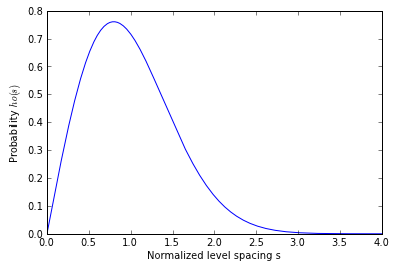

In [17]:
plot(s, rhos)
xlabel('Normalized level spacing s')
ylabel('Probability $\rho(s)$')

## Serial calculation of nearest neighbor eigenvalue distribution

In this section we numerically construct and diagonalize a large number of GOE random matrices
and compute the nerest neighbor eigenvalue distribution. This comptation is done on a single core.

In [6]:
def serial_diffs(num, N):
    """Compute the nearest neighbor distribution for num NxX matrices."""
    diffs = ensemble_diffs(num, N)
    normalized_diffs = normalize_diffs(diffs)
    return normalized_diffs

In [7]:
serial_nmats = 1000
serial_matsize = 50

In [8]:
%timeit -r1 -n1 serial_diffs(serial_nmats, serial_matsize)

1 loops, best of 1: 1.19 s per loop

In [9]:
serial_diffs = serial_diffs(serial_nmats, serial_matsize)

The numerical computation agrees with the predictions of Wigner, but it would be nice to get more
statistics. For that we will do a parallel computation.

&lt;matplotlib.text.Text at 0x3475bd0&gt;

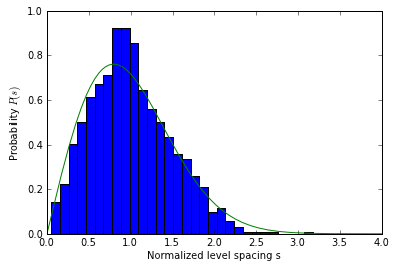

In [10]:
hist_data = hist(serial_diffs, bins=30, normed=True)
plot(s, rhos)
xlabel('Normalized level spacing s')
ylabel('Probability $P(s)$')

## Parallel calculation of nearest neighbor eigenvalue distribution

Here we perform a parallel computation, where each process constructs and diagonalizes a subset of
the overall set of random matrices.

In [11]:
def parallel_diffs(rc, num, N):
    nengines = len(rc.targets)
    num_per_engine = num/nengines
    print "Running with", num_per_engine, "per engine."
    ar = rc.apply_async(ensemble_diffs, num_per_engine, N)
    diffs = np.array(ar.get()).flatten()
    normalized_diffs = normalize_diffs(diffs)
    return normalized_diffs

In [12]:
client = Client()
view = client[:]
view.run('rmtkernel.py')
view.block = False

In [13]:
parallel_nmats = 40*serial_nmats
parallel_matsize = 50

In [14]:
%timeit -r1 -n1 parallel_diffs(view, parallel_nmats, parallel_matsize)

Running with 10000 per engine.
1 loops, best of 1: 14 s per loop